In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve

## Set up Network

In [3]:
## Parameters

# task_type='Iris_classification'
task_type='Regression'
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])

Nin: int = 4
Ninter: int = 0
Nout: int = 1

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 0.5  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

# R_update: str = 'propto'
R_update: str = 'deltaR'
R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1, 0.85, 1.05, 1., 2.95, 0.55])

# training length
iterations = 640  # number of sampled of p

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
# use_p_tag: bool = False
# access_interNodes: bool = True  # access and change pressure at interNodes (nodes between input and output) or not
access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
stay_sample: int = 2  # how many loop iterations to stay under the same sampled p

## Networkx sizes
scale: float = 5.0
squish: float = 0.01

In [4]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         Nout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         Ninter)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)

alpha_vec [0.5]
input M mismatches output and input


In [5]:
## Assign input and output nodes a.f.o lattice size and row choice
input_nodes_arr, inter_nodes_arr, output_nodes_arr, ground_nodes_arr = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs.Ninter, Variabs.Nout)

In [6]:
print('input_nodes_arr ', input_nodes_arr)
print('inter_nodes_arr ', inter_nodes_arr)
print('output_nodes_arr ', output_nodes_arr)
print('ground_nodes_arr ', ground_nodes_arr)

input_nodes_arr  [0 1 2 3]
inter_nodes_arr  []
output_nodes_arr  [4]
ground_nodes_arr  [5]


In [7]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [8]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(input_nodes_arr, \
                           output_nodes_arr, \
                           inter_nodes_arr, \
                           ground_nodes_arr,)
Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [9]:
## Initiate internal flow network state class

if access_interNodes:
    State = Network_State(Variabs.Nin, Variabs.Nout, Ninter)
else:
    State = Network_State(Variabs.Nin, Variabs.Nout)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
else:
    State.initiate_resistances(BigClass)
BigClass.add_State(State)  # add to big class

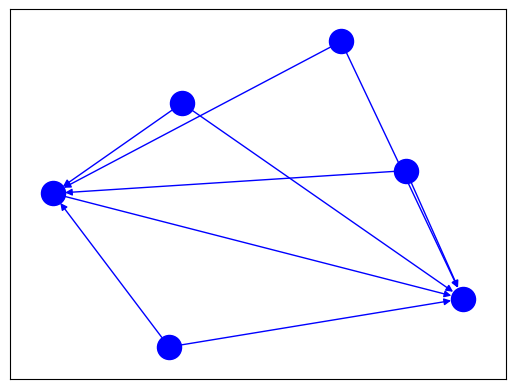

NET is ready


In [10]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=False)
BigClass.add_NET(NET)  # add to big class

## Train

In [11]:
for i in range(Variabs.iterations):
    print('i', i)
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % 15 == 0 and task_type == 'Iris_classification':
        targets_mat = zeros([3, 3])
        for j in range(3):
            State.draw_p_means_Iris(Variabs, j)
            # print('means[j]', State.input_drawn)
            State.solve_flow_given_problem(BigClass, "measure_for_mean")  # measure and don't change resistances
            # print('targets[j]', State.output)
            targets_mat[j] = State.output
        State.assign_targets_Iris(targets_mat)
        print(targets_mat)
    if use_p_tag:
        k = (i//stay_sample)*2 + i%2
    else:
        k = (i//stay_sample)
    print('k', k)
    State.draw_p_in_and_desired(Variabs, k)
    #print('p_drawn ', State.input_drawn)
    # print('desired output', State.desired)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    # print('output meausred', State.output)
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
    # if not i % 2:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.calc_loss(BigClass)
        State.update_input_dual(BigClass)
        State.update_output_dual(BigClass)
        if access_interNodes:
            State.update_inter_dual(BigClass)
        State.solve_flow_given_problem(BigClass, "dual")  # measure and don't change resistances
        State.update_Rs(BigClass)

i 0
k 0
input_drawn [0.90376504 0.59550637 1.22011334 0.76543344]
desired output= [0.63623771]
output measured= [0.69696364]
i 1
k 1
input_drawn [1.3713725  0.18533015 0.84980306 0.26082148]
desired output= [0.48130482]
output measured= [0.53346544]
loss= [[-0.05216062]
 [-0.06072593]]
time= 1
input_dual_nxt= [-0.0020026   0.00175664  0.00158591  0.00216108]
output_dual_nxt [-0.00070021]
i 2
k 2
input_drawn [0.14044582 1.95320196 1.96337131 0.14249427]
desired output= [0.91679952]
output measured= [0.83894122]
i 3
k 3
input_drawn [1.78774452 0.32817857 1.00146424 0.0110086 ]
desired output= [0.58526431]
output measured= [0.62622034]
loss= [[-0.04095603]
 [ 0.0778583 ]]
time= 2
input_dual_nxt= [ 0.09786135 -0.09653803 -0.05714417 -0.00781119]
output_dual_nxt [0.01263714]
i 4
k 4
input_drawn [1.57538687 1.16620995 0.91149536 1.76689829]
desired output= [0.87411369]
output measured= [1.08093251]
i 5
k 5
input_drawn [1.49123892 0.61576358 0.44898032 1.37768807]
desired output= [0.59685244]

i 152
k 152
input_drawn [0.85176684 1.92367116 1.41295897 1.13227852]
desired output= [0.97896685]
output measured= [1.01229716]
i 153
k 153
input_drawn [1.47312571 1.30436534 0.86728066 0.94688622]
desired output= [0.79335071]
output measured= [0.82354048]
loss= [[-0.03018977]
 [-0.0333303 ]]
time= 77
input_dual_nxt= [-0.0009757   0.00097248  0.00085686  0.00029112]
output_dual_nxt [-0.0002964]
i 154
k 154
input_drawn [1.82095581 0.31556477 0.15974112 1.56141582]
desired output= [0.53233319]
output measured= [0.56747367]
i 155
k 155
input_drawn [0.42163812 1.05900009 0.32336982 1.36687858]
desired output= [0.49257605]
output measured= [0.51873246]
loss= [[-0.02615641]
 [-0.03514048]]
time= 78
input_dual_nxt= [ 0.00628579 -0.00333954 -0.00073503  0.00087387]
output_dual_nxt [-0.00021895]
i 156
k 156
input_drawn [1.25856631 0.19957254 0.63542132 0.34862738]
desired output= [0.42241752]
output measured= [0.43815055]
i 157
k 157
input_drawn [1.42248366 1.36517784 0.14607406 0.95117631]
de

i 338
k 338
input_drawn [0.9804295  0.34138715 0.17362636 0.32439451]
desired output= [0.2911879]
output measured= [0.29233429]
i 339
k 339
input_drawn [0.96813624 1.59528141 0.79183917 1.28990168]
desired output= [0.79122668]
output measured= [0.7963468]
loss= [[-0.00512012]
 [-0.0011464 ]]
time= 170
input_dual_nxt= [-2.44249902e-05  2.49131425e-03  1.22830324e-03  1.91832906e-03]
output_dual_nxt [-0.0010014]
i 340
k 340
input_drawn [1.60393372 1.09053107 0.23325582 0.28490167]
desired output= [0.54550039]
output measured= [0.54603911]
i 341
k 341
input_drawn [0.45533588 0.7476314  1.86219803 0.42911296]
desired output= [0.72628746]
output measured= [0.72800887]
loss= [[-0.0017214 ]
 [-0.00053871]]
time= 171
input_dual_nxt= [-6.79218239e-04 -2.02772195e-04  9.63267747e-04  8.52787024e-05]
output_dual_nxt [-0.00010761]
i 342
k 342
input_drawn [0.09663315 1.99688638 1.22853177 1.9024881 ]
desired output= [0.911254]
output measured= [0.91771075]
i 343
k 343
input_drawn [0.05951876 1.8045

output measured= [0.44125667]
i 539
k 539
input_drawn [1.77232089 0.1042211  0.81341732 1.60632896]
desired output= [0.65067958]
output measured= [0.65259839]
loss= [[-0.00191881]
 [-0.0001225 ]]
time= 270
input_dual_nxt= [ 0.0008707  -0.00093893  0.00041584  0.00141424]
output_dual_nxt [-0.00018982]
i 540
k 540
input_drawn [0.17472151 0.60536063 1.60854357 0.5867464 ]
desired output= [0.60809089]
output measured= [0.60856994]
i 541
k 541
input_drawn [0.51870204 0.18229648 1.27644597 1.47281642]
desired output= [0.58065774]
output measured= [0.58201278]
loss= [[-0.00135504]
 [-0.00047906]]
time= 271
input_dual_nxt= [ 0.00015066 -0.0001853  -0.00014546  0.00038809]
output_dual_nxt [1.16318415e-05]
i 542
k 542
input_drawn [0.42931174 0.05349857 1.60903563 0.95431845]
desired output= [0.57278723]
output measured= [0.57359516]
i 543
k 543
input_drawn [0.8760041  0.19099237 1.69457104 0.0320642 ]
desired output= [0.59644827]
output measured= [0.59639882]
loss= [[ 4.94501418e-05]
 [-8.079358

i 586
k 586
input_drawn [0.43487333 0.52206548 1.72860681 0.43865823]
desired output= [0.64566162]
output measured= [0.64624844]
i 587
k 587
input_drawn [1.78629482 1.97386848 1.87095785 0.89448121]
desired output= [1.2199055]
output measured= [1.22094066]
loss= [[-0.00103515]
 [-0.00058682]]
time= 294
input_dual_nxt= [3.02945127e-04 3.25447428e-04 3.19105131e-05 1.02180818e-04]
output_dual_nxt [-0.00012883]
i 588
k 588
input_drawn [1.25183507 1.50837456 0.68800737 1.80291477]
desired output= [0.84174349]
output measured= [0.84311992]
i 589
k 589
input_drawn [0.48099616 0.86421283 0.69465653 1.47774968]
desired output= [0.56643109]
output measured= [0.56758355]
loss= [[-0.00115246]
 [-0.00137642]]
time= 295
input_dual_nxt= [ 8.63206777e-05  7.21350168e-05 -7.44592215e-07  3.64128884e-05]
output_dual_nxt [-3.08553261e-05]
i 590
k 590
input_drawn [1.31374796 1.68417386 1.29404719 0.76503758]
desired output= [0.93391252]
output measured= [0.93459956]
i 591
k 591
input_drawn [1.96476817 1.

## Plots

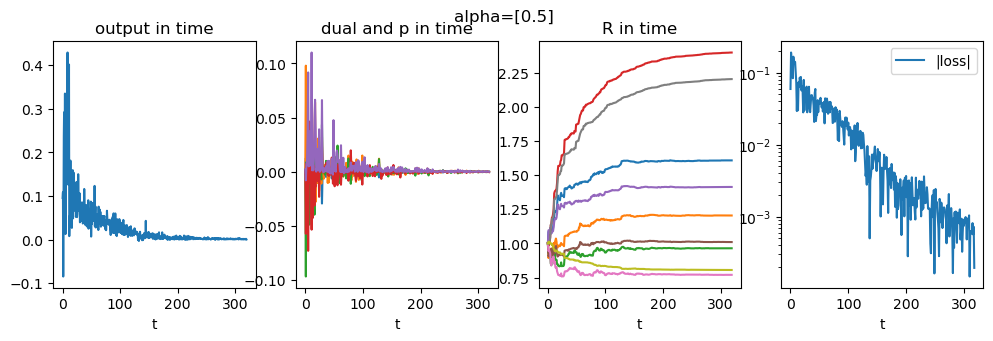

In [12]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M)
else:
        plot_functions.plot_importants(State, Variabs, State.desired_in_t)

## Statistics

### Error

In [13]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

final_err 0.0010651356233749105


### Accuracy

In [14]:
accuracy = zeros(np.shape(Variabs.dataset)[0])
for i, datapoint in enumerate(Variabs.dataset):
    State.draw_p_in_and_desired(Variabs, i)
    State.solve_flow_given_problem(BigClass, "measure")  # measure and don't change resistances
    accuracy[i] = statistics.calculate_accuracy(State.output, State.target_mat, Variabs.targets[i])

input_drawn [0.90376504 0.59550637 1.22011334 0.76543344]
desired output= [0.63623771]
output measured= [0.63666227]


AttributeError: 'Network_State' object has no attribute 'target_mat'

In [ ]:
Variabs.targets

In [ ]:
np.mean(accuracy)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(np.mean(np.mean(np.abs(State.loss_in_t[1::stay_sample]), axis=1), axis=1))

In [ ]:
State.R_in_t